# PVC IMPORT model training and testing : prophet + xgboost

## importing dependencies

In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from prophet import Prophet
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

## Function declaration
Following functions are declared in this section
- function for preprocessing
- function for spliting data into train and testing set
- function for prophet model
- function for XGBoost model 

### Data Preprocessing

In [37]:
def preprocess(dset):

    # selecting only required column
    dset = dset[['ds', 'unitp', 'y']]

    # handling missing values with mean fill method
    dset_mean = dset['unitp'].mean()
    dset['unitp'].fillna(dset_mean, inplace=True)

    dset['cost'] = dset['unitp']*dset['y']

    # formatting date column as per datetime format
    dset['ds'] = pd.to_datetime(dset['ds'], format='mixed')
    dset.sort_values(by='ds', inplace=True)

    # resampling dataset to weekwise frequency
    # resampled_dataset = dset.groupby(pd.Grouper(key='ds', freq='W')).sum().reset_index()
    resampled_dataset = (dset.groupby(pd.Grouper(key='ds', freq='7D', label='left', closed='left')).sum().reset_index())

    # creating lag features
    resampled_dataset['lag_1'] = resampled_dataset['y'].shift(1)
    resampled_dataset.dropna(inplace=True)
    
    return resampled_dataset

### Training and Testing Data Split
- this function takes the dataset to be predicted
- splits the dataset into training and testing dataset
- split is done in 70:30 ratio
- and returns the training, testing and dataset that can be fitted into the model

In [38]:
def train_test_split(df):
    split = int(df['ds'].count()*0.8)
    
    train = df.iloc[:split+1]
    test = df.iloc[split:]
    
    return train, test

### Prophet: forecasting and plotting
- this function intialises a prophet model
- adds the exogenous variables
- fits the model with training data
- forecast the desired period
- visualises the training and forecasting

this funcation will also display evaluation matrix comparing performance of the model<br>
following are the paramteres used for evaluation
1. Mean Absolute Error
2. Mean Absolute Percentage Error
3. Mean Square Error
4. Root Mean Square Error

In [39]:
def prophet(dset, name):

    # splitting dataset into training, testing and model fitting dataset
    train, test = train_test_split(dset)
    train = train[['ds', 'cost', 'y']]
    test = test[['ds', 'cost', 'y']]
    mtest = test[['ds', 'cost']]

    # train-test forecasting
    model = Prophet(interval_width=0.9)
    model.add_regressor('cost', standardize=False)
    fitted_model = model.fit(train)
    forecast = fitted_model.predict(mtest)

    # evaluating model
    actual = test['y']
    forecast_total = forecast['yhat']
    forecast_upper = forecast['yhat_upper']
    forecast_lower = forecast['yhat_lower']

    # Mean Squared Error (MSE)
    mse = mean_squared_error(actual,forecast_total)
    mse_upper = mean_squared_error(actual,forecast_upper)
    mse_lower = mean_squared_error(actual,forecast_lower)
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse_upper = np.sqrt(mse_upper)
    rmse_lower = np.sqrt(mse_lower)
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual,forecast_total)
    mae_upper = mean_absolute_error(actual,forecast_upper)
    mae_lower = mean_absolute_error(actual,forecast_lower)
    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual,forecast_total) * 100  # convert to %
    mape_upper = mean_absolute_percentage_error(actual,forecast_upper) * 100
    mape_lower = mean_absolute_percentage_error(actual,forecast_lower) * 100

    # plotting
    plt.figure(figsize=(14,5))
    plt.plot(train['ds'], train['y'], color='orange', label='training data', lw=1)
    plt.plot(test['ds'], test['y'], color='lightblue', label='actual data', lw=1)

    smallest = min(mape, mape_upper, mape_lower)

    if (smallest == mape):
        fin_mse = mse
        fin_rmse = rmse
        fin_mae = mae
        fin_mape = mape
        fin_predicted_import = forecast_total
        plt.plot(test['ds'], forecast['yhat'], color='green', label='testing forecast with yhat', lw=1)
        
    elif (smallest == mape_upper):
        fin_mse = mse_upper
        fin_rmse = rmse_upper
        fin_mae = mae_upper
        fin_mape = mape_upper
        fin_predicted_import = forecast_upper
        plt.plot(test['ds'], forecast['yhat_upper'], color='green', label='testing forecast with yhat_upper', lw=1)
        
    else:
        fin_mse = mse_lower
        fin_rmse = rmse_lower
        fin_mae = mae_lower
        fin_mape = mape_lower
        fin_predicted_import = forecast_lower
        plt.plot(test['ds'], forecast['yhat_lower'], color='green', label='testing forecast with yhat_upper', lw=1)

    # Visual validation of yhat, yhat_upper, yhat_lower
    # plt.plot(test['ds'], forecast['yhat'], color='green', label='predicted data', lw=1)
    # plt.plot(test['ds'], forecast['yhat_upper'], color='blue', label='predicted data using yhat_upper', lw=1)
    # plt.plot(test['ds'], forecast['yhat_lower'], color='red', label='predicted data using yhat_lower', lw=1)

    plt.title(f'{name} Import forecast with Prophet (WO hyperparameters).')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('import quantity')
    plt.tight_layout()
    plt.show()
    
    print(f'Actual import: {actual.sum()} MTs')
    print(f'Predicted import: {fin_predicted_import.sum()} MTs')
    print(f"MSE: {fin_mse:.2f}")
    print(f"RMSE: {fin_rmse:.2f}")
    print(f"MAE: {fin_mae:.2f}")
    print(f"MAPE: {fin_mape:.2f}%")
    print(f'Accuracy: {100-fin_mape:.2f}%  (Approx.)')



#### Prophet model hyperparameters tunning


In [40]:
# Suppress Prophet logs and warnings
from tqdm import tqdm
import logging
warnings.filterwarnings("ignore")
logger = logging.getLogger('prophet')
logger.setLevel(logging.CRITICAL)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

def tunner_prophet(dset,list):

    train, test = train_test_split(dset)
    train = train[['ds', 'cost', 'y']]
    test = test[['ds', 'cost', 'y']]
    mtest = test[['ds', 'cost']]
   
    model = Prophet(interval_width=0.9, changepoint_prior_scale=list[0], seasonality_prior_scale=list[1], seasonality_mode=list[2], changepoint_range=list[3])
    model.add_regressor('cost', standardize=False)
    fitted_model = model.fit(train)
    forecast = fitted_model.predict(mtest)

    actual = test['y']
    forecast_total = forecast['yhat']

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual,forecast_total) * 100  # convert to %

    return mape

def tuning_prophet(dset):

    dset= dset[['ds', 'cost', 'y']]

    # hyperparameters search space defination
    param1 = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1.0]      # changepoint_prior_scale
    param2 = [0.1, 0.01, 1.0, 5.0, 10.0, 15.0, 20.0, 30.0]       # seasonality_prior_scale
    param3 = ['additive', 'multiplicative']                     # seasonality_mode
    param4 = [0.6, 0.7, 0.8, 0.9, 0.95]                          # changepoint_range

    # calculating total combinations to try
    total_combinations = len(param1) * len(param2) * len(param3) * len(param4)

    # setting best mape as infinity ans best params as none for future update
    best_mape = float('inf')
    best_params = None

    # setting progress bar for total combination 
    count = 1
    # trying each parameters ans finding best with lowest mape score
    with tqdm(total=total_combinations, desc="🔧 Tuning Prophet", ncols=80) as pbar:
        for mode in param3:
            for cp_range in param4:
                for seas_prior in param2:
                    for cp_prior in param1:
                        params = [cp_prior, seas_prior, mode, cp_range]
                        try:
                            mape = tunner_prophet(dset, params)

                            if mape < best_mape:
                                best_params = params
                                best_mape = mape

                            count += 1

                        except Exception:
                            pass

                        pbar.update(1)

    # closing progress bar and returning best params
    # pbar.close()
    print(f"\n✅ Best MAPE: {best_mape:.4f}% with parameters: {best_params}")
    
    return best_params


#### Prophet with hyperparameters

In [41]:
def prophetwp(dset, name, params):

    # splitting dataset into training, testing and model fitting dataset
    train, test = train_test_split(dset)
    train = train[['ds', 'cost', 'y']]
    test = test[['ds', 'cost', 'y']]
    mtest = test[['ds', 'cost']]

    # train-test forecasting
    model = Prophet(interval_width=0.9, changepoint_prior_scale=params[0], seasonality_prior_scale=params[1], seasonality_mode=params[2], changepoint_range=params[3])
    model.add_regressor('cost', standardize=False)
    fitted_model = model.fit(train)
    forecast = fitted_model.predict(mtest)

    # evaluating model
    actual = test['y']
    forecast_total = forecast['yhat']
    forecast_upper = forecast['yhat_upper']
    forecast_lower = forecast['yhat_lower']

    # Mean Squared Error (MSE)
    mse = mean_squared_error(actual,forecast_total)
    mse_upper = mean_squared_error(actual,forecast_upper)
    mse_lower = mean_squared_error(actual,forecast_lower)
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse_upper = np.sqrt(mse_upper)
    rmse_lower = np.sqrt(mse_lower)
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual,forecast_total)
    mae_upper = mean_absolute_error(actual,forecast_upper)
    mae_lower = mean_absolute_error(actual,forecast_lower)
    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual,forecast_total) * 100  # convert to %
    mape_upper = mean_absolute_percentage_error(actual,forecast_upper) * 100
    mape_lower = mean_absolute_percentage_error(actual,forecast_lower) * 100

    # plotting
    plt.figure(figsize=(14,5))
    plt.plot(train['ds'], train['y'], color='orange', label='training data', lw=1)
    plt.plot(test['ds'], test['y'], color='lightblue', label='actual data', lw=1)

    smallest = min(mape, mape_upper, mape_lower)

    if (smallest == mape):
        fin_mse = mse
        fin_rmse = rmse
        fin_mae = mae
        fin_mape = mape
        fin_predicted_import = forecast_total
        plt.plot(test['ds'], forecast['yhat'], color='green', label='testing forecast with yhat', lw=1)
        
    elif (smallest == mape_upper):
        fin_mse = mse_upper
        fin_rmse = rmse_upper
        fin_mae = mae_upper
        fin_mape = mape_upper
        fin_predicted_import = forecast_upper
        plt.plot(test['ds'], forecast['yhat_upper'], color='green', label='testing forecast with yhat_upper', lw=1)
        
    else:
        fin_mse = mse_lower
        fin_rmse = rmse_lower
        fin_mae = mae_lower
        fin_mape = mape_lower
        fin_predicted_import = forecast_lower
        plt.plot(test['ds'], forecast['yhat_lower'], color='green', label='testing forecast with yhat_upper', lw=1)

    # Visual validation of yhat, yhat_upper, yhat_lower
    # plt.plot(test['ds'], forecast['yhat'], color='green', label='predicted data', lw=1)
    # plt.plot(test['ds'], forecast['yhat_upper'], color='blue', label='predicted data using yhat_upper', lw=1)
    # plt.plot(test['ds'], forecast['yhat_lower'], color='red', label='predicted data using yhat_lower', lw=1)

    plt.title(f'{name} Import forecast with Prophet (W hyperparameters).')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('import quantity')
    plt.tight_layout()
    plt.show()
    
    print(f'Actual import: {actual.sum()} MTs')
    print(f'Predicted import: {fin_predicted_import.sum()} MTs')
    print(f"MSE: {fin_mse:.2f}")
    print(f"RMSE: {fin_rmse:.2f}")
    print(f"MAE: {fin_mae:.2f}")
    print(f"MAPE: {fin_mape:.2f}%")
    print(f'Accuracy: {100-fin_mape:.2f}%  (Approx.)')



### XGBoost :forecasting and plotting
- this function intialises a XGBoost model
- process data for model fitting
- fits the model with training data
- forecast the desired period
- visualises the training and forecasting

this funcation will also display evaluation matrix comparing performance of the model<br>
following are the paramteres used for evaluation
1. Mean Absolute Error
2. Mean Absolute Percentage Error
3. Mean Square Error
4. Root Mean Square Error

In [42]:
def xgboost(dset, name):

    # extracting features from datetime columns and droping original datetime column
    dset.loc[:, 'week'] = dset['ds'].dt.isocalendar().week

    train, test = train_test_split(dset)
    x_train, y_train = train[['week', 'cost', 'lag_1']], train['y']
    y_test = test[['week', 'cost', 'lag_1']] 

    # initialising model and fitting it with training and testing dataset
    model = XGBRegressor(objective='reg:absoluteerror', n_estimators=100)
    model.fit(x_train, y_train)
    forecast = model.predict(y_test)

    # ploting training, testing, and predicted dataset    
    plt.figure(figsize=(14,5))
    plt.plot(train['ds'], train['y'], color='orange', label='training data', lw=1)
    plt.plot(test['ds'], test['y'], color='lightblue', label='testing data', lw=1)
    plt.plot(test['ds'], forecast, color='green', label='test forecast', lw=1)
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('import quantity')
    plt.title(f'{name} import forecast with XGBoost (WO Hyperparameters)')
    plt.tight_layout()
    plt.show()
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(test['y'], forecast)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(test['y'], forecast)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(test['y'], forecast) * 100  # convert to %

    actual = test['y'].sum()
    print(f'actual import: {actual}')
    predicted = forecast.sum()
    print(f'predicted import: {predicted}')
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f'Accuracy: {100-mape:.2f}% (Approx.)')


#### XGBoost model hyperparameters tunning

In [43]:
# Suppress Prophet logs and warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
logger = logging.getLogger('xgboost')
logger.setLevel(logging.CRITICAL)

def tunner_xgboost(dset, params):

    # extracting features from datetime columns and droping original datetime column
    dset.loc[:, 'week'] = dset['ds'].dt.isocalendar().week

    train, test = train_test_split(dset)
    x_train, y_train = train[['week', 'cost', 'lag_1']], train['y']
    y_test = test[['week', 'cost', 'lag_1']] 

    # initialising model and fitting it with training and testing dataset
    model = XGBRegressor(learning_rate = params[0], n_estimators = params[1], max_depth = params[2], objective=params[3], eval_metric=params[4])
    model.fit(x_train, y_train)
    
    # forecasting with testing dataset
    forecast = model.predict(y_test)

    mape = mean_absolute_percentage_error(test['y'], forecast) * 100  # convert to %

    return mape

def tuning_xgboost(dset):

    dset= dset[['ds', 'cost', 'lag_1', 'y']]

    # hyperparameters search space defination
    learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
    n_estimators = [100, 200, 300, 500, 700]
    max_depth = [3, 5, 7, 9, 11]
    objective = ['reg:squarederror', 'reg:absoluteerror']
    eval_metric = ['rmse', 'mae']

    # calculating total combinations to try
    total_combinations = len(learning_rate) * len(n_estimators) * len(max_depth) * len(objective) * len(eval_metric) 

    # setting best mape as infinity and best params as none for future update
    best_mape = float('inf')
    best_params = None

    count = 1
    # trying each parameters ans finding best with lowest mape score
    with tqdm(total=total_combinations, desc="🔧 Tuning XGBoost", ncols=80) as pbar:
        for em in eval_metric:
            for obj in objective:
                for md in max_depth:
                    for ne in n_estimators:
                        for lr in learning_rate:
                            params = [lr, ne, md, obj, em]
                            try:
                                mape = tunner_xgboost(dset, params)

                                if mape < best_mape:
                                    best_params = params
                                    best_mape = mape

                            except Exception:
                                pass
                            
                            pbar.update(1)
                        
    # closing progress bar and returning best params
    # pbar.close()
    print(f"\n✅ Best MAPE: {best_mape:.4f}% with parameters: {best_params}")
    
    return best_params


#### XGBoost with Hyperparameters

In [44]:
def xgboostwp(dset, name, params):

    # extracting features from datetime columns and droping original datetime column
    dset.loc[:, 'week'] = dset['ds'].dt.isocalendar().week

    train, test = train_test_split(dset)
    x_train, y_train = train[['week', 'cost', 'lag_1']], train['y']
    y_test = test[['week', 'cost', 'lag_1']] 

    # initialising model and fitting it with training and testing dataset
    model = XGBRegressor(learning_rate = params[0], n_estimators = params[1], max_depth = params[2], objective=params[3], eval_metric=params[4])
    model.fit(x_train, y_train)
    forecast = model.predict(y_test)

    # ploting training, testing, and predicted dataset    
    plt.figure(figsize=(14,5))
    plt.plot(train['ds'], train['y'], color='orange', label='training data', lw=1)
    plt.plot(test['ds'], test['y'], color='lightblue', label='testing data', lw=1)
    plt.plot(test['ds'], forecast, color='green', label='test forecast', lw=1)
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('import quantity')
    plt.title(f'{name} import forecast with XGBoost (WO Hyperparameters)')
    plt.tight_layout()
    plt.show()
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(test['y'], forecast)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(test['y'], forecast)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(test['y'], forecast) * 100  # convert to %

    actual = test['y'].sum()
    print(f'actual import: {actual}')
    predicted = forecast.sum()
    print(f'predicted import: {predicted}')
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f'Accuracy: {100-mape:.2f}% (Approx.)')


## Loadind data and preprocessing

In [ ]:
df = pd.read_excel('C:/Users/Dhyey2.Patel/Desktop/Dhyey2.Patel/PVC_import_analysis_&_forecasting/data/preprocessed data/fin_PVC_dataset.xlsx')
df.rename(columns={'Date': 'ds', 'K Range': 'k', 'Fin Cif ($/MT)': 'unitp', 'Fin QTY (MTs)': 'y'}, inplace=True)
df = df[['ds', 'k', 'unitp', 'y']]

# converting dates to datetime format & sorting
df['ds'] = pd.to_datetime(df['ds'], format='mixed')
df.sort_values(by='ds', inplace=True)

# loading maping dataset
map = pd.read_excel('C:/Users/Dhyey2.Patel/Desktop/Dhyey2.Patel/PVC_import_analysis_&_forecasting/data/preprocessed data/cat_to_num_mapping.xlsx', engine='openpyxl')

# making dictionary of mapping dataset
k_map =  dict(zip(map['k_level'], map['k_code']))

# mapping grades of df to their code from mapping dataset
df['k_code'] = df['k'].map(k_map)

# dropping previous grade column
df.drop('k', axis=1, inplace=True)

print(df.tail())
print('Total import: ',df['y'].sum())

              ds  unitp        y  k_code
97912 2025-06-04  684.0  280.000     2.0
98220 2025-06-04  676.0   12.398     2.0
98221 2025-06-04  676.0   10.198     2.0
97911 2025-06-04  684.0  280.000     2.0
98199 2025-06-04  676.0  117.404     2.0
Total import:  13013663.026074188


## Forecasting individual K-Level

In [53]:
def k_level_forecast(code, name, p_params, x_params):   

    dset = df[(df['k_code'] == code)]
    
    resampled_dset = preprocess(dset)
    
    tunning_dset = resampled_dset.iloc[:(int(resampled_dset['ds'].count()*0.7))+1]
    
    prophet(resampled_dset, name)

    if (p_params == None):
        prophet_params = tuning_prophet(tunning_dset)
    else:
        prophet_params = p_params

    prophetwp(resampled_dset, name, prophet_params)

    xgboost(resampled_dset, name) 

    if (x_params == None):
        xgboost_params = tuning_xgboost(tunning_dset)
    else:
        xgboost_params = x_params

    xgboostwp(resampled_dset, name, xgboost_params) 

### Very High K

12:13:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


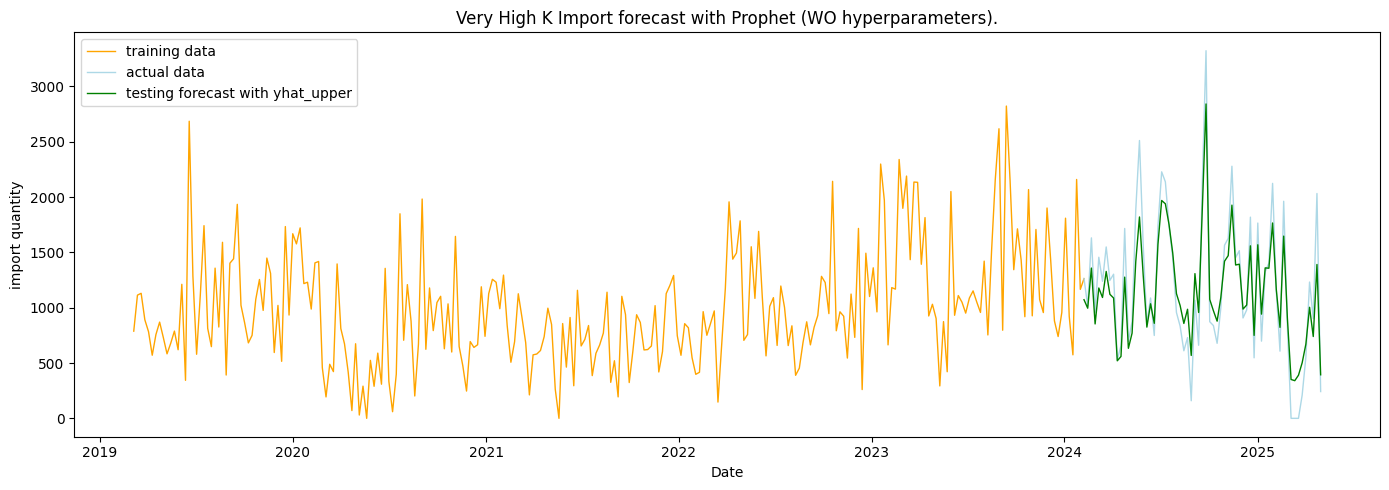

Actual import: 77677.81314999999 MTs
Predicted import: 74636.54263049748 MTs
MSE: 62507.09
RMSE: 250.01
MAE: 205.46
MAPE: 7491656472610724864.00%
Accuracy: -7491656472610724864.00%  (Approx.)


🔧 Tuning Prophet: 100%|██████████████████████| 640/640 [38:15<00:00,  3.59s/it]



✅ Best MAPE: 15.6223% with parameters: [1.0, 1.0, 'multiplicative', 0.95]


12:52:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


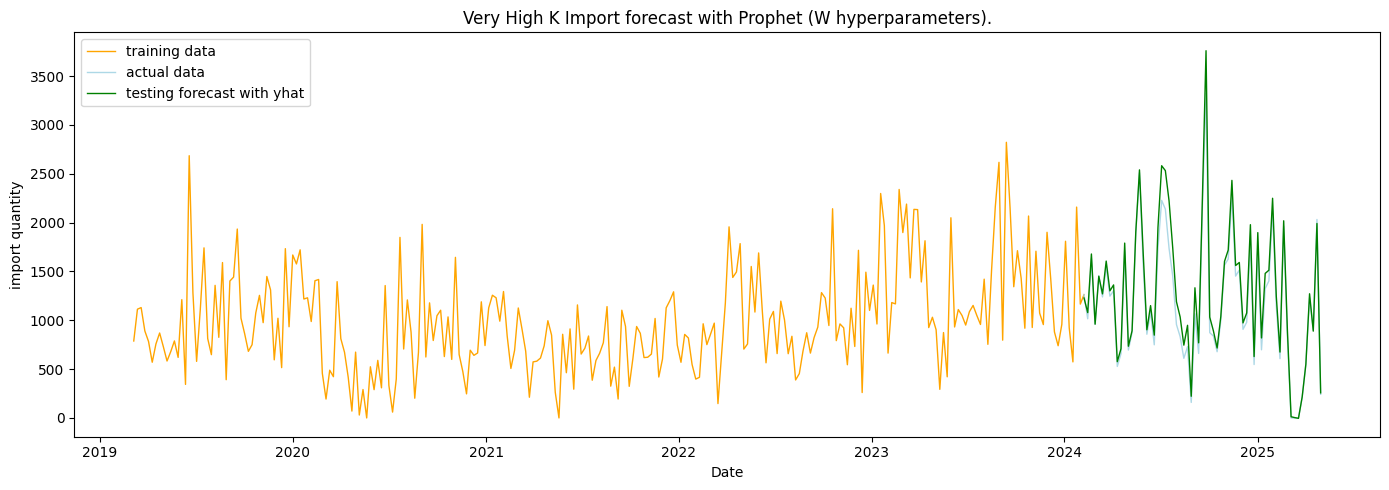

Actual import: 77677.81314999999 MTs
Predicted import: 84158.79291501564 MTs
MSE: 21424.22
RMSE: 146.37
MAE: 102.80
MAPE: 138221458561168672.00%
Accuracy: -138221458561168576.00%  (Approx.)


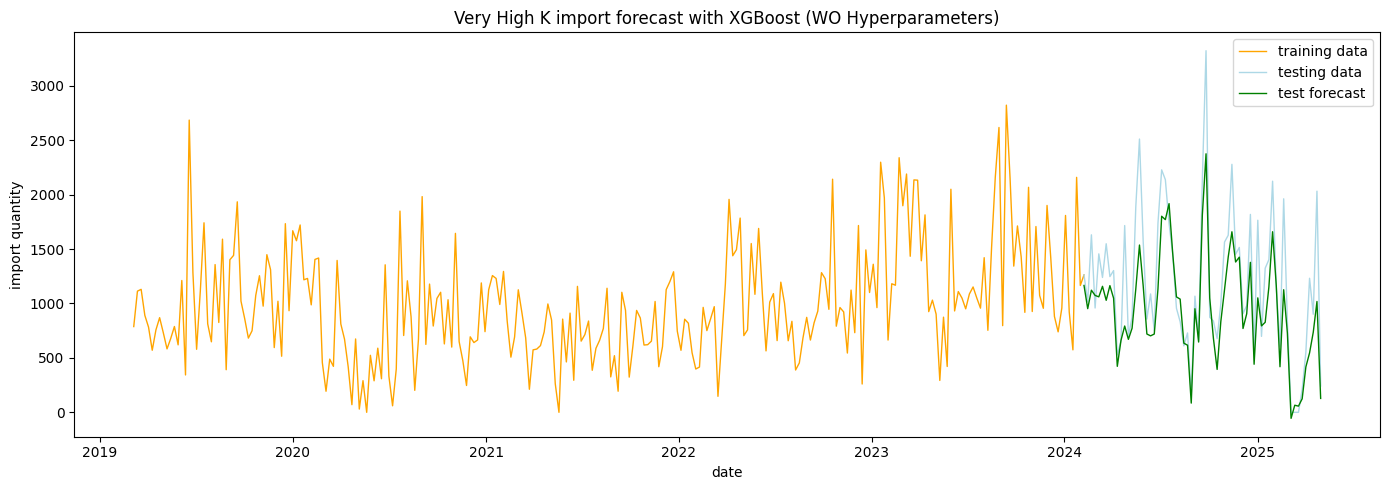

actual import: 77677.81314999999
predicted import: 61804.203125
MSE: 149298.93
RMSE: 386.39
MAE: 276.52
MAPE: 1230262881063756288.00%
Accuracy: -1230262881063756288.00% (Approx.)


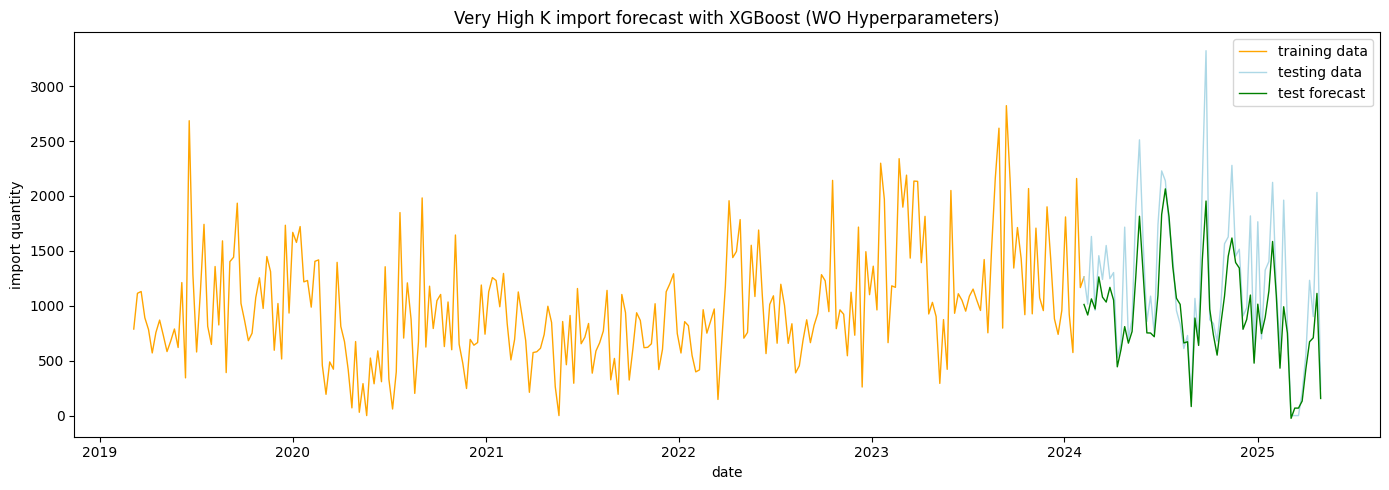

actual import: 77677.81314999999
predicted import: 61169.0078125
MSE: 160715.42
RMSE: 400.89
MAE: 275.80
MAPE: 1117814188195890432.00%
Accuracy: -1117814188195890304.00% (Approx.)


In [54]:
prophet_params = None # [1.0, 30.0, 'multiplicative', 0.9]
xgboost_params = [0.1, 100, 5, 'reg:absoluteerror', 'rmse']
k_level_forecast(1, 'Very High K', prophet_params, xgboost_params) 

### High K

In [ ]:
prophet_params = None
xgboost_params = None
k_level_forecast(2, 'High K', prophet_params, xgboost_params)

### Medium K

In [ ]:
prophet_params = None
xgboost_params = None
k_level_forecast(3, 'Medium K', prophet_params, xgboost_params)

### Low K

In [ ]:
prophet_params = None
xgboost_params = None
k_level_forecast(4, 'Low K', prophet_params, xgboost_params)

## Influencing Factors

| Factor             | Type              | Possible Values / Description                  |
|--------------------|-------------------|------------------------------------------------|
| FOB (free onboard) price (China) | Numerical         | Numerical figures                               |
| Demand             | Qualitative       | low, steady, high, very high                   |
| Freight            | Numerical         | Numerical figures                               |
| Demand in India    | Qualitative       | low, steady, high, very high                   |
| Open market        | Numerical         | Numerical figures                               |
| Benchmark prices   | Numerical         | ICIS and Platts benchmark figures              |
| Co-producers       | Qualitative       | less active, steady, highly active             |
